In [2]:
# Import all the libraries

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold,train_test_split, cross_val_score, GridSearchCV, KFold #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay, make_scorer, mean_squared_error,classification_report,confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc,roc_auc_score
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier


In [3]:
# Load in the Dataset to a df
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')

In [45]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# Check Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-null  object 
 9   Fraud                        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


In [5]:
# Correct Datatype to datetime

df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])

In [6]:
# Verify Datatype

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Transaction ID               10000 non-null  int64         
 1   Customer ID                  10000 non-null  int64         
 2   Transaction Amount           10000 non-null  float64       
 3   Transaction Date and Time    10000 non-null  datetime64[ns]
 4   Merchant Category            10000 non-null  object        
 5   Location                     10000 non-null  object        
 6   Previous Transaction Amount  10000 non-null  float64       
 7   Time Since Last Transaction  10000 non-null  float64       
 8   Device Type                  10000 non-null  object        
 9   Fraud                        10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 781.4+ KB


In [7]:
# Check Class Balance - welp this is bad

df['Fraud'].value_counts()

Fraud
No     8608
Yes    1392
Name: count, dtype: int64

In [8]:
# See Data Head

df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


<Axes: ylabel='Transaction Amount'>

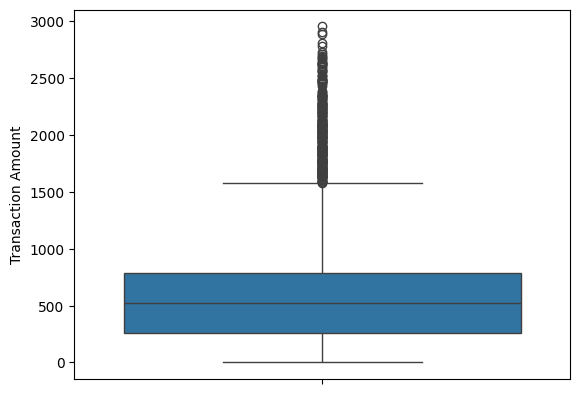

In [23]:
# check Transaction Amount Distribution
sns.boxplot(df['Transaction Amount'])

In [9]:
# Check how many unique customers - 3664/10000

df['Customer ID'].value_counts()

Customer ID
4854    10
3708    10
1018     9
1661     9
2016     9
        ..
1003     1
1025     1
2417     1
3554     1
1308     1
Name: count, Length: 3664, dtype: int64

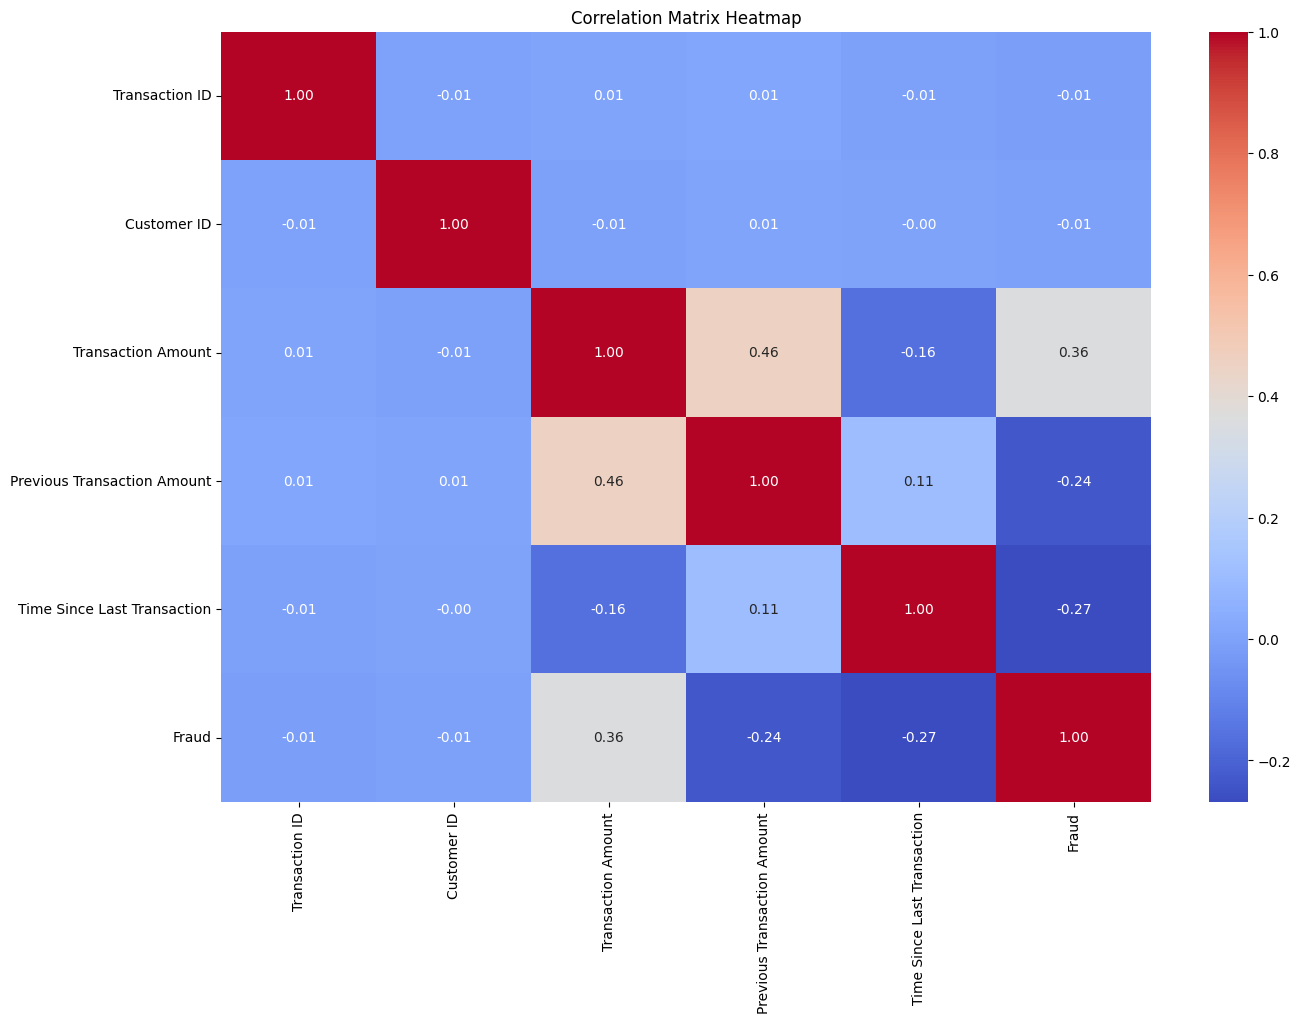

In [22]:
# heatmap of correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [10]:
# Correct Output (Fraud) to Binary using Mapping
# Convert 'Yes' to 1 and 'No' to 0
df['Fraud'] = df['Fraud'].map({'Yes': 1, 'No': 0})

In [11]:
# Verify Done Correctly

df['Fraud'].value_counts()

Fraud
0    8608
1    1392
Name: count, dtype: int64

In [12]:
df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud'],
      dtype='object')

In [13]:
# Group by 'Customer ID' and calculate the sum and count of 'Fraud'
summary = df.groupby('Customer ID')['Fraud'].agg(['sum', 'count'])

# Calculate the percentage of fraud (1s) in each job role
summary['Fraud_Percentage'] = (summary['sum'] / summary['count']) * 100

# Display the result
summary[['Fraud_Percentage']]

,Fraud_Percentage
Customer ID,
1000,0.0
1001,40.0
1002,0.0
1003,0.0
1004,0.0
...,...
4995,0.0
4996,20.0
4997,0.0


# Merchant Category no Strong Relationship

In [14]:
# Group by 'Merchant Category' and calculate the sum and count of 'Fraud'
summary = df.groupby('Merchant Category')['Fraud'].agg(['sum', 'count'])

# Calculate the percentage of fraud (1s) in each job role
summary['Fraud_Percentage'] = (summary['sum'] / summary['count']) * 100

# Display the result
summary[['Fraud_Percentage']]

,Fraud_Percentage
Merchant Category,
Clothing,14.571150
Dining,13.866153
Electronics,14.322251
Groceries,13.817448
Travel,12.984997


# Location - Showing Possible Strong Relation to Fraud
Hypothesis: Location will have heavy influence on determining whether a transaction is fraud or not
Null Hypothesis: Location does not have any influence on whether a transaction is fraud or not.

In [15]:
# Group by 'Location' and calculate the sum and count of 'Fraud'
summary = df.groupby('Location')['Fraud'].agg(['sum', 'count'])

# Calculate the percentage of fraud (1s) in each job role
summary['Fraud_Percentage'] = (summary['sum'] / summary['count']) * 100

# Display the result
summary[['Fraud_Percentage']]

,Fraud_Percentage
Location,
Chicago,10.861619
Houston,27.265065
Los Angeles,9.304703
New York,10.664523
San Francisco,8.253968


# Even Split for Device Type

In [16]:
# Group by 'Device Type' and calculate the sum and count of 'Fraud'
summary = df.groupby('Device Type')['Fraud'].agg(['sum', 'count'])

# Calculate the percentage of fraud (1s) in each job role
summary['Fraud_Percentage'] = (summary['sum'] / summary['count']) * 100

# Display the result
summary[['Fraud_Percentage']]

,Fraud_Percentage
Device Type,
desktop,13.973627
mobile,13.864607


In [18]:
df['Time Since Last Transaction'].describe()

count    10000.000000
mean       677.040726
std        432.386769
min          1.000000
25%        295.523894
50%        653.143168
75%       1048.479972
max       1694.715674
Name: Time Since Last Transaction, dtype: float64

In [24]:
df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud', 'Time Since Trans Bins'],
      dtype='object')

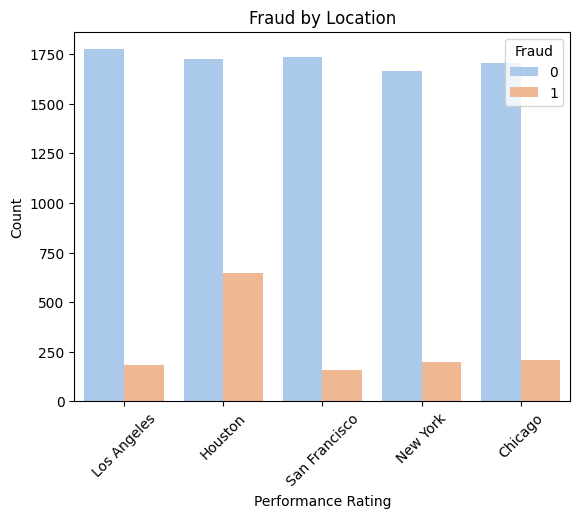

In [25]:
sns.countplot(x='Location', hue='Fraud', data=df, palette='pastel')
plt.title('Fraud by Location')
plt.xlabel('Performance Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Feature Engineering Time
# Time Since Last Transaction - lets put it in Bins for visualization

# Define the bins and labels(25%,50%,75%,infinity)
ltv_bins = [0, 295, 650, 1048, float('inf')]
ltv_labels = ['0 - 294', '295-649', '650-1047', '1048+']

# Create the LTV_cat column in the transaction_level DataFrame
df['Time Since Trans Bins'] = pd.cut(df['Time Since Last Transaction'], bins=ltv_bins, labels=ltv_labels, right=False)
df['Time Since Trans Bins'].value_counts()

Time Since Trans Bins
650-1047    2510
1048+       2507
0 - 294     2496
295-649     2487
Name: count, dtype: int64

# Time Since Last Transaction Categories showing strong relation to Fraud
Hypothesis: Short Time since Last Transaction has a higher chance of being Fraud
Null Hypothesis: Time since Last Transaction has no effect on Fraud

In [21]:
# Group by 'Device Type' and calculate the sum and count of 'Fraud'
summary = df.groupby('Time Since Trans Bins')['Fraud'].agg(['sum', 'count'])

# Calculate the percentage of fraud (1s) in each job role
summary['Time Since Trans Bins'] = (summary['sum'] / summary['count']) * 100

# Display the result
summary[['Time Since Trans Bins']]

C:\Users\etjdr\AppData\Local\Temp\ipykernel_2308\1796970337.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('Time Since Trans Bins')['Fraud'].agg(['sum', 'count'])


,Time Since Trans Bins
Time Since Trans Bins,
0 - 294,29.366987
295-649,15.802171
650-1047,5.737052
1048+,4.866374


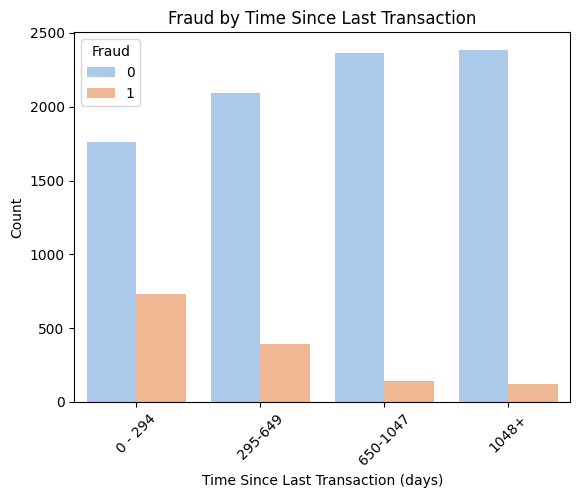

In [26]:
sns.countplot(x='Time Since Trans Bins', hue='Fraud', data=df, palette='pastel')
plt.title('Fraud by Time Since Last Transaction')
plt.xlabel('Time Since Last Transaction (days)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [27]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,Time Since Trans Bins
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,0,295-649
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,0,1048+
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,0,650-1047
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,0,0 - 294
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,0,1048+


In [32]:
# Average Transaction Amount per Unique Customer ID

df['Avg Trans Amt'] = df.groupby('Customer ID')['Transaction Amount'].transform('mean')
df.head(10)

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,Time Since Trans Bins,Avg Trans Amt
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,0,295-649,439.330623
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,0,1048+,1199.425957
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,0,650-1047,565.511158
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,0,0 - 294,726.110747
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,0,1048+,469.563006
5,6,2095,395.323790,2023-01-01 00:05:00,Dining,New York,421.926105,548.706785,mobile,0,295-649,231.696571
6,7,4772,967.649233,2023-01-01 00:06:00,Groceries,Los Angeles,1226.767073,331.319088,desktop,0,295-649,863.249349
7,8,4092,16.558875,2023-01-01 00:07:00,Dining,Chicago,78.163605,662.724041,desktop,0,650-1047,305.449898
8,9,2638,533.075713,2023-01-01 00:08:00,Dining,Los Angeles,553.556682,896.814583,mobile,0,650-1047,462.492542
9,10,3169,909.749227,2023-01-01 00:09:00,Electronics,Chicago,571.664421,505.032036,mobile,0,295-649,698.318286


In [58]:
# Total Spend per Customer

df['Total Spend'] = df.groupby('Customer ID')['Transaction Amount'].transform('sum')
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,Time Since Trans Bins,Avg Trans Amt,Total Spend,Customer Lifespan
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,0,295-649,439.330623,1317.991869,2521.608540
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,0,1048+,1199.425957,4797.703830,1459.237224
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,0,650-1047,565.511158,1131.022316,1717.354769
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,0,0 - 294,726.110747,2178.332241,1405.783572
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,0,1048+,469.563006,939.126011,2110.731873


In [39]:
# Data only covers 7 days (2023-01-01 to 2023-01-07)
# I wanted to feature engineer this by month, but because it doesn't have all 12 months, it won't be useful
# Not going to use this date, could do by day or hour but doesn't seem useful at this time

df['Transaction Date and Time'].describe()

count                  10000
mean     2023-01-04 11:19:30
min      2023-01-01 00:00:00
25%      2023-01-02 17:39:45
50%      2023-01-04 11:19:30
75%      2023-01-06 04:59:15
max      2023-01-07 22:39:00
Name: Transaction Date and Time, dtype: object

In [41]:
df['Time Since Last Transaction'].describe()

count    10000.000000
mean       677.040726
std        432.386769
min          1.000000
25%        295.523894
50%        653.143168
75%       1048.479972
max       1694.715674
Name: Time Since Last Transaction, dtype: float64

In [44]:
# Customer Life Span calculated by summing the time from last transaction for each unique customer ID

df['Customer Lifespan'] = df.groupby('Customer ID')['Time Since Last Transaction'].transform('sum')
df.head(10)

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,Time Since Trans Bins,Avg Trans Amt,Total Spend,Customer Lifespan
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,0,295-649,439.330623,1317.991869,2521.608540
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,0,1048+,1199.425957,4797.703830,1459.237224
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,0,650-1047,565.511158,1131.022316,1717.354769
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,0,0 - 294,726.110747,2178.332241,1405.783572
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,0,1048+,469.563006,939.126011,2110.731873
5,6,2095,395.323790,2023-01-01 00:05:00,Dining,New York,421.926105,548.706785,mobile,0,295-649,231.696571,463.393142,953.025898
6,7,4772,967.649233,2023-01-01 00:06:00,Groceries,Los Angeles,1226.767073,331.319088,desktop,0,295-649,863.249349,1726.498698,694.560037
7,8,4092,16.558875,2023-01-01 00:07:00,Dining,Chicago,78.163605,662.724041,desktop,0,650-1047,305.449898,610.899795,2054.532785
8,9,2638,533.075713,2023-01-01 00:08:00,Dining,Los Angeles,553.556682,896.814583,mobile,0,650-1047,462.492542,1849.970167,4116.918905
9,10,3169,909.749227,2023-01-01 00:09:00,Electronics,Chicago,571.664421,505.032036,mobile,0,295-649,698.318286,4888.228000,3445.048138


# Model Time?!

In [46]:
df.columns

Index(['Transaction ID', 'Customer ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant Category', 'Location',
       'Previous Transaction Amount', 'Time Since Last Transaction',
       'Device Type', 'Fraud', 'Time Since Trans Bins', 'Avg Trans Amt',
       'Total Spend', 'Customer Lifespan'],
      dtype='object')

In [47]:
# Model TIME
# Lets Do some variables, throw everything we've got, and go from there

# Split Data for Model

X = df[['Transaction Amount','Merchant Category','Location','Previous Transaction Amount','Time Since Last Transaction','Device Type','Time Since Trans Bins',
        'Avg Trans Amt','Total Spend','Customer Lifespan']]
y = df['Fraud']

numeric_columns = ['Transaction Amount','Previous Transaction Amount','Time Since Last Transaction','Avg Trans Amt','Total Spend','Customer Lifespan']
categorical_columns = ['Merchant Category','Location','Device Type','Time Since Trans Bins',]

# reserve 30% for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

# create a pre-processing pipeline which includes the steps of Scaling numeric variables and encoding categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorical_columns)
    ]
)

Cross Evalutation - Lets See if any of these can predict on the imbalanced dataset

In [48]:
# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Evaluate each model using cross-validation
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=3,n_jobs=-1)
    print(f"{name} F1 Scores (weighted): {scores.mean():.3f} ± {scores.std():.3f}")


Logistic Regression F1 Scores (weighted): 0.910 ± 0.004
KNN F1 Scores (weighted): 0.875 ± 0.005
Naive Bayes F1 Scores (weighted): 0.864 ± 0.002
Decision Tree F1 Scores (weighted): 0.877 ± 0.009
Random Forest F1 Scores (weighted): 0.924 ± 0.007
SVM F1 Scores (weighted): 0.899 ± 0.004


In [49]:
# Define the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)

# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', logreg)
])

# Fit the model to the training data
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      2584
           1       0.96      0.47      0.63       416

    accuracy                           0.92      3000
   macro avg       0.94      0.74      0.80      3000
weighted avg       0.93      0.92      0.91      3000



# As Expected Models are Struggling to Predict the weakly represented class

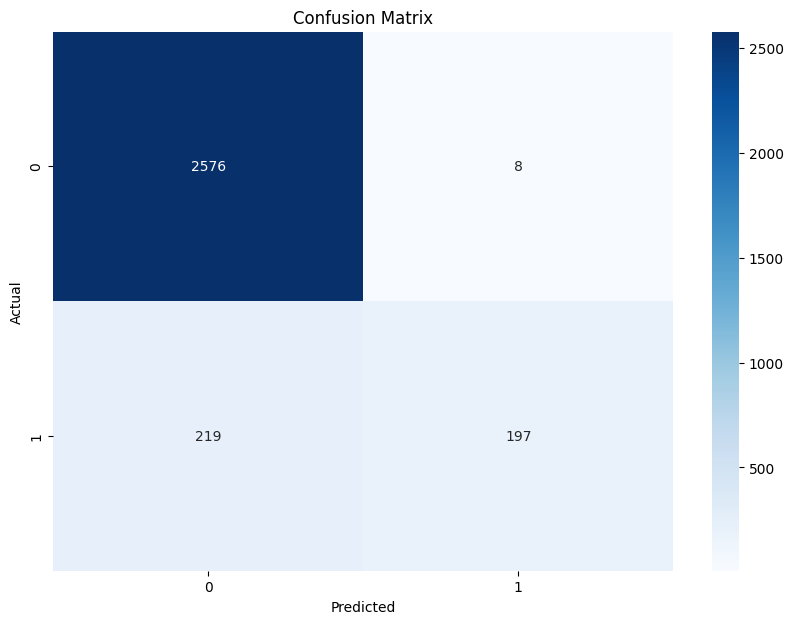

In [50]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      2599
           1       0.94      0.56      0.70       401

    accuracy                           0.94      3000
   macro avg       0.94      0.78      0.83      3000
weighted avg       0.94      0.94      0.93      3000



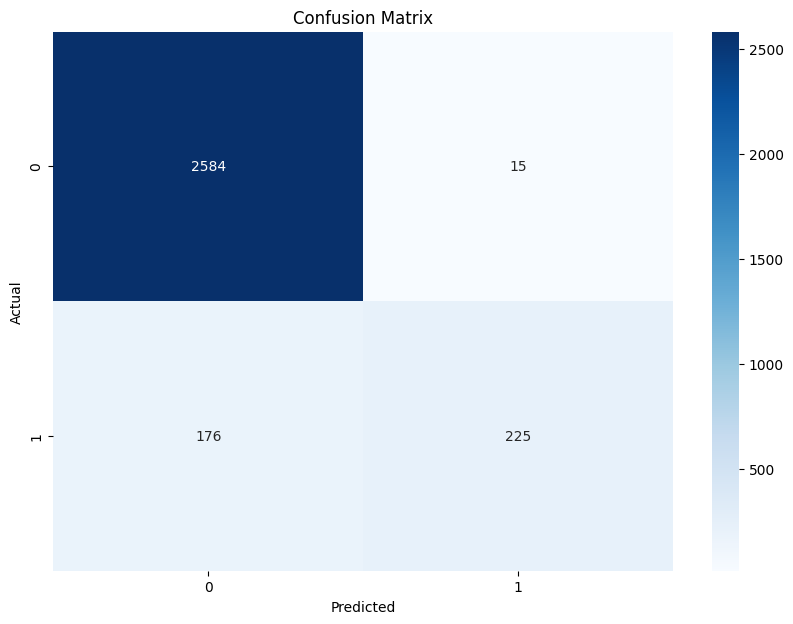

In [51]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create a pipeline with the preprocessor and a RandomForestClassifier
pipeline_rforest_rev = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

# Train the model
pipeline_rforest_rev.fit(X_train, y_train)

# Make predictions
y_pred = pipeline_rforest_rev.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Random Forest Performing Slightly Better, but its still barely over 50/50 on the important side
# Hyper Parameter Tuning Random Forest

In [52]:
# GridSearch Run (Swap Models & Params)

def run_grid_search(pipeline, param_grid, X_train, y_train):
    """
    Run GridSearchCV on the provided pipeline and parameter grid.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline object with preprocessor and model
    - param_grid: dict, parameter grid for GridSearchCV
    - X_train: Training features
    - y_train: Training labels

    Returns:
    - best_estimator: Best model from GridSearchCV
    - best_params: Best parameters from GridSearchCV
    - best_score: Best score achieved by the best model
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_estimator = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    return best_estimator, best_params, best_score

# Assuming 'preprocessor' is defined and 'X_train', 'y_train' are your training data

# Replace with your selected model and corresponding parameter grid
selected_model = RandomForestClassifier() # Put model you want to use here
param_grid = {
    'classifier__n_estimators': [100, 200, 300], # Change Params using above listed arrays
    'classifier__max_depth': [None, 10, 20, 30]
}

# Create a pipeline with the selected model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', selected_model)
])

# Run grid search
best_estimator, best_params, best_score = run_grid_search(pipeline, param_grid, X_train, y_train)

print("Best Estimator:", best_estimator) # Output gives Model with Parameters assigned
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Estimator: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Transaction Amount',
                                                   'Previous Transaction '
                                                   'Amount',
                                                   'Time Since Last '
                                                   'Transaction',
                                                   'Avg Trans Amt',
                                                   'Total Spend',
                                                   'Customer Lifespan']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Merchant Category',
                     

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4307
           1       0.93      0.59      0.72       693

    accuracy                           0.94      5000
   macro avg       0.93      0.79      0.84      5000
weighted avg       0.94      0.94      0.93      5000



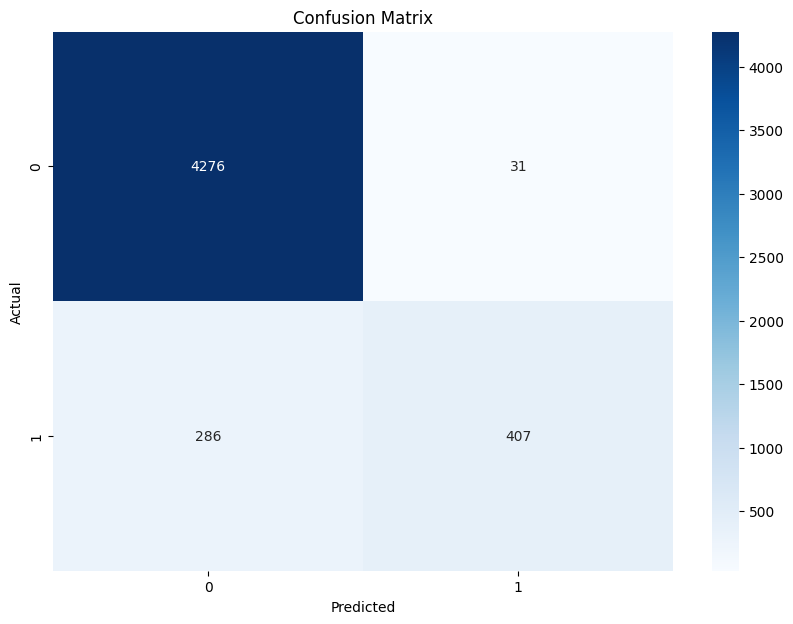

In [60]:
# Try Random Forest With New Parameters

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Create a pipeline with the preprocessor and a RandomForestClassifier
pipeline_rforest_rev = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=20,n_estimators=200))
])

# Train the model
pipeline_rforest_rev.fit(X_train, y_train)

# Make predictions
y_pred = pipeline_rforest_rev.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()